# a couple of ways to do two-way ANOVA with Python
Here is my version of [this article](https://www.marsja.se/three-ways-to-carry-out-2-way-anova-with-python/)
There are a lot of errors, and so, I'd fixed it

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

La idea intuitiva detrás del funcionamiento básico de un ANOVA es la siguiente:

1) Calcular la media de cada uno de los grupos.

2) Calcular la varianza de las medias de los grupos. Esta es la varianza explicada por la variable grupo, y se le conoce como intervarianza.

3) Calcular las varianzas internas de cada grupo y obtener su promedio. Esta es la varianza no explicada por la variable grupo, y se le conoce como intravarianza.

Acorde a la hipótesis nula de que todas las observaciones proceden de la misma población (tienen la misma media y varianza), es de esperar que la intervarianza y la intravarianza sean iguales. A medida que las medias de los grupos se alejan las unas de las otras, la intervarianza aumenta y deja de ser igual a la intravarianza.

El estadístico estudiado en el ANOVA ( 𝐹𝑟𝑎𝑡𝑖𝑜
 ), se calcula como el ratio entre la varianza de las medias de los grupos (intervarianza o varianza de las medias) y el promedio de la varianza dentro de los grupos (intravarianza o varianza de grupo). Este estadístico sigue una distribución F de Fisher-Snedecor. Si se cumple la hipótesis nula, el estadístico  𝐹
  adquiere el valor de 1 puesto que la intervarianza es igual a la intravarianza. A medida que las medias de los grupos se alejan entre ellas, mayor es la intervarianza en comparación a la intravarianza, lo que genera valores de  𝐹
  superiores a 1, que tienen una probabilidad asociada menor (menor el p-value).

En concreto, si  $𝑆_1^2$ es la la varianza de una muestra de tamaño  $𝑁_1$ extraída de una población normal de varianza  $𝜎_1^2$, y  $𝑆_2^2$ es la la varianza de una muestra de tamaño  $𝑁_2$ extraída de una población normal de varianza  $𝜎_2^2$, y ambas muestras son independientes, el cociente:

$ F = \frac{\frac{S_1^2}{\sigma_1^2}}{\frac{S_2^2}{\sigma_2^2}} $

Donde:
- $S_1^2 $ es la variabilidad entre los grupos.
- $\sigma_1^2$ es la varianza dentro de los grupos.
- $S_2^2$ es la variabilidad dentro de los grupos.
- $ \sigma_2^2 $ es la varianza total.

se distribuye como una variable F de Fisher-Snedecor con $( 𝑁_1y  𝑁_2 )$ grados de libertad. En el caso del ANOVA, dado que dos de las condiciones son la normalidad de los grupos y la homocedasticidad de varianza ( $𝜎_1^2$= $𝜎_2^2$ ), el valor  𝐹
  se puede obtener dividiendo las dos varianzas calculadas a partir de las muestras (intervariaza e intravarianza).

Existen diferentes tipos de ANOVA dependiendo de la si se trata de datos independientes (ANOVA entre sujetos), si son pareados (ANOVA de mediciones repetidas), si comparan la variable cuantitativa dependiente contra los niveles de una única variable cualitativa o factor (ANOVA de una vía) o frente a dos factores (ANOVA de dos vías). Este último puede ser a su vez aditivo o de interacción (los factores son independientes o no lo son). Cada uno de estos tipos de ANOVA tiene una serie de requerimientos propios.

El ANOVA de una vía, también conocido como ANOVA con un factor o modelo factorial de un solo factor, permite estudiar si existen diferencias significativas entre la media de una variable aleatoria continua en los diferentes niveles de otra variable cualitativa o factor, cuando los datos no están pareados. Es una extensión de los t-test independientes para más de dos grupos.

Las hipótesis contrastadas en un ANOVA de un factor son:

* 𝐻0: No hay diferencias entre las medias de los diferentes grupos :  𝜇1=𝜇2...=𝜇𝑘=𝜇
 
* 𝐻1: Al menos un par de medias son significativamente distintas la una de la otra.



## Datos

Este dataset contiene información sobre el crecimiento de los odontoblastos (dientes) en 10 cobayas (guinea pigs) bajo tres niveles de dosificación de Vitamina C (0.5, 1, y 2 mg) con dos métodos de administración (jugo de naranja - OJ, y ácido ascórbico - VC)

* len: Longitud del diente.
* supp: Tipo de suplemento (VC o OJ).
* dose: Dosis en miligramos (0.5, 1.0, 2.0).

### Razones para usar ANOVA en este dataset:
Comparar Múltiples Grupos:

* Suplemento (supp): Comparar las medias de longitud de los dientes entre los suplementos OJ (jugo de naranja) y VC (ácido ascórbico).
* Dosis (dose): Comparar las medias de longitud de los dientes entre diferentes niveles de dosis (0.5, 1.0, 2.0 mg).

#### Evaluar Interacciones:

Ver si hay una interacción entre el tipo de suplemento y la dosis en la longitud de los dientes.

#### Detección de Diferencias Significativas:

Identificar si las diferencias observadas en las medias son estadísticamente significativas o simplemente se deben al azar.


In [2]:
datafile = "../../data/ToothGrowth.csv"
data = pd.read_csv(datafile).drop("Unnamed: 0", axis=1)
data.sample(10)

,len,supp,dose
15,17.3,VC,1.0
43,26.4,OJ,1.0
26,26.7,VC,2.0
10,16.5,VC,1.0
4,6.4,VC,0.5
38,16.5,OJ,0.5
59,23.0,OJ,2.0
29,29.5,VC,2.0
13,17.3,VC,1.0
42,23.6,OJ,1.0


## Número de grupos, observaciones por grupo y distribución de las observaciones¶

Se identifica el número de grupos y cantidad de observaciones por grupo para determinar si es un modelo equilibrado. También se calculan la media y desviación típica de caga grupo.

In [3]:
# Número de observaciones por grupo
data.groupby("supp").size()

supp
OJ    30
VC    30
dtype: int64

In [4]:
# Média y desviación típica por grupo
data.groupby("supp").agg(["mean", "std"]).T

supp              OJ         VC
len  mean  20.663333  16.963333
     std    6.605561   8.266029
dose mean   1.166667   1.166667
     std    0.634270   0.634270

## Análisis gráfico
Dos de las representación más útiles antes de realizar un ANOVA son los gráficos Box-Plot y los Violin-Plot.



/opt/homebrew/anaconda3/envs/mlcourse/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/anaconda3/envs/mlcourse/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/envs/mlcourse/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


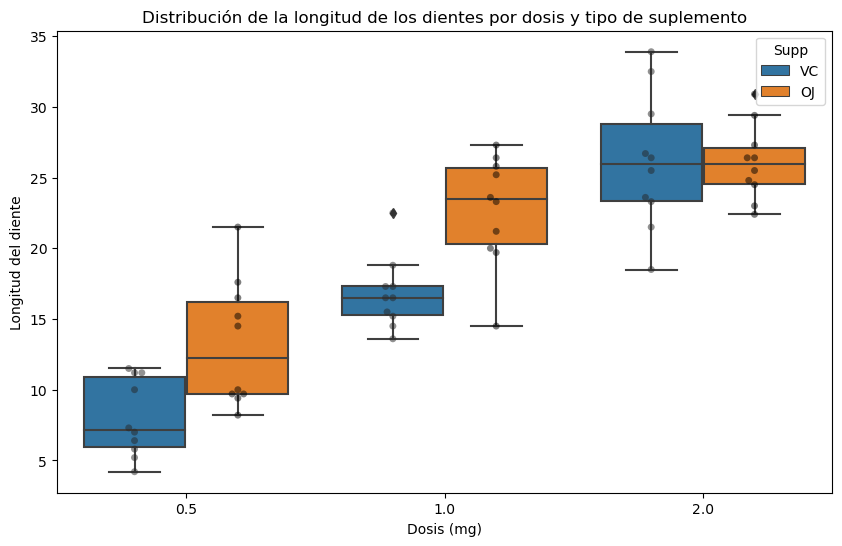

In [5]:
# Crear la figura y los ejes
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Crear un boxplot para visualizar la distribución de los datos
sns.boxplot(x="dose", y="len", hue="supp", data=data, ax=ax)

# Agregar un swarmplot para ver la dispersión de los datos
sns.swarmplot(x="dose", y="len", hue="supp", data=data, dodge=True, color='black', alpha=0.5, ax=ax)

# Ajustar la leyenda para evitar duplicados
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title='Supp')

# Etiquetas de los ejes y título
ax.set_xlabel("Dosis (mg)")
ax.set_ylabel("Longitud del diente")
ax.set_title("Distribución de la longitud de los dientes por dosis y tipo de suplemento")

# Mostrar la gráfica
plt.show()

1) Efecto de la Dosis:

* A medida que aumenta la dosis de Vitamina C, la longitud de los dientes también aumenta para ambos tipos de suplemento.
Las medianas de la longitud de los dientes son claramente mayores para las dosis de 1.0 y 2.0 mg en comparación con la dosis de 0.5 mg.

* Las medianas de la longitud de los dientes son claramente mayores para las dosis de 1.0 y 2.0 mg en comparación con la dosis de 0.5 mg.

2) Comparación entre suplementos:

* Parece que el jugo de naranja (OJ) supera al acido ascórbico (vc) Excepto para la dosis de 1mg, donde tienen la misma mediana.

3) Variabilidad:

* La variabilidad en la longitud de los dientes (indicada por la altura de las cajas y la longitud de los bigotes) tiende a ser mayor con dosis más altas, especialmente para el ácido ascórbico (VC) a 2.0 mg.



/opt/homebrew/anaconda3/envs/mlcourse/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:113: FutureWarning: The provided callable <function mean at 0x107821af0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  plot_data = data.groupby(['trace', 'x']).aggregate(func).reset_index()


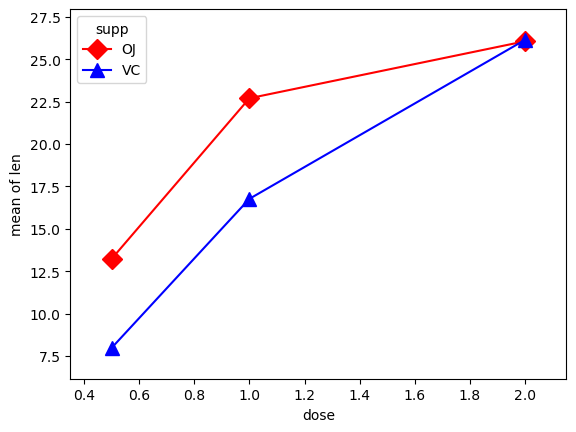

In [7]:
fig = interaction_plot(data.dose, data.supp, data.len,
             colors=['red','blue'], markers=['D','^'], ms=10)

#### Interpretación del Gráfico de Interacción

El gráfico de interacción muestra la media de la longitud de los dientes (mean of len) en función de la dosis de Vitamina C (dose) para dos tipos de suplementos: jugo de naranja (OJ) y ácido ascórbico (VC).

#### Análisis de la Gráfica

1)Efecto de la Dosis:

* La longitud de los dientes aumenta con la dosis de Vitamina C para ambos tipos de suplementos. Esto sugiere que mayores dosis de Vitamina C están asociadas con un mayor crecimiento dental.

2) Comparación entre Suplementos:

* Para la dosis de 0.5 mg, el jugo de naranja (OJ) tiene una mayor longitud promedio de los dientes en comparación con el ácido ascórbico (VC).
* Para la dosis de 1.0 mg, el jugo de naranja (OJ) sigue mostrando una mayor longitud promedio de los dientes en comparación con el ácido ascórbico (VC).
* Para la dosis de 2.0 mg, ambos suplementos parecen tener efectos similares, alcanzando aproximadamente la misma longitud promedio de los dientes.

# Calculation of Sum of Squares
The calculations of the sum of squares (the variance in the data) are quite simple using Python. 
First, we start with getting the sample size (N) and the degree of freedoms needed. 
We will use them later to calculate the mean square. 
After we have the degree of freedom we continue with the calculation of the sum of squares.

# Degrees of Freedom

In [9]:
N = len(data.len) # calcular el numiero de observaciones
df_a = len(data.supp.unique()) - 1 # grados de libertad del factor A
df_b = len(data.dose.unique()) - 1 # grados de libertad del factor B
df_axb = df_a*df_b # grados de libertad de la interacción
df_w = N - (len(data.supp.unique())*len(data.dose.unique())) # grados de libertad del error

# Sum of Squares
For the calculation of the sum of squares A, B and Total we will need to have the grand mean. Using Pandas DataFrame method mean on the dependent variable only will give us the grand mean:

In [10]:
grand_mean = data['len'].mean()

# Sum of Squares A – supp
We start with calculation of Sum of Squares for the factor A (supp).

In [45]:
# Inicializar la suma de cuadrados del factor A
ssq_a = 0

# Iterar sobre cada nivel único del suplemento
for supp_level in data.supp.unique():
    # Filtrar los datos para el nivel actual del suplemento
    subset = data[data.supp == supp_level]

    # Calcular la media de la longitud de los dientes para el nivel actual del suplemento
    group_mean = subset.len.mean()

    # Calcular la diferencia al cuadrado entre la media del grupo y la media general
    squared_diff = (group_mean - grand_mean) ** 2

    # Multiplicar la diferencia al cuadrado por el número de observaciones en el grupo
    weighted_squared_diff = squared_diff * len(subset)

    # Sumar al total de la suma de cuadrados del factor A
    ssq_a += weighted_squared_diff

# Mostrar el resultado
print(f"Suma de cuadrados del factor A (ssq_a): {ssq_a}")

Suma de cuadrados del factor A (ssq_a): 205.3500000000003


# Sum of Squares B – dose
Calculation of the second Sum of Square, B (dose), is pretty much the same but over the levels of that factor.

In [46]:
# Calcular la suma de cuadrados del factor B (dosis)
ssq_b = 0

for dose_level in data.dose.unique():
    subset = data[data.dose == dose_level]
    group_mean = subset.len.mean()
    squared_diff = (group_mean - grand_mean) ** 2
    weighted_squared_diff = squared_diff * len(subset)
    ssq_b += weighted_squared_diff

print(f"Suma de cuadrados del factor A (ssq_b): {ssq_b}")

Suma de cuadrados del factor A (ssq_b): 2426.4343333333345


# Sum of Squares Total

In [47]:
# Calcular la suma de cuadrados total
ssq_t = sum((data.len - grand_mean) ** 2)
ssq_t

3452.2093333333332

# Sum of Squares Within (error/residual)
Next, we need to calculate the Sum of Squares Within which is sometimes referred to as error or residual.

In [48]:
# Calcular la suma de cuadrados dentro de los grupos (error)
# Calcular la suma de cuadrados dentro de los grupos (error)
ssq_w = 0
for supp_level in data.supp.unique():
    for dose_level in data.dose.unique():
        subset = data[(data.supp == supp_level) & (data.dose == dose_level)]
        group_mean = subset.len.mean()
        squared_diff = (subset.len - group_mean) ** 2
        ssq_w += sum(squared_diff)
ssq_w

712.106

# Sum of Squares interaction
Since we have a two-way design we need to calculate the Sum of Squares for the interaction of A and B.

In [49]:
# Calcular la suma de cuadrados de la interacción
ssq_axb = ssq_t - ssq_a - ssq_b - ssq_w
ssq_axb

108.31899999999837

# Mean Squares
We continue with the calculation of the mean square for each factor, the interaction of the factors, and within.

In [50]:
# Mean Square A
ms_a = ssq_a/df_a

# Mean Square B
ms_b = ssq_b/df_b

# Mean Square AxB
ms_axb = ssq_axb/df_axb

# Mean Square Within/Error/Residual
ms_w = ssq_w/df_w

# F-ratio
The F-statistic is simply the mean square for each effect and the interaction 
divided by the mean square for within (error/residual).

In [51]:
# F-ratio A
f_a = ms_a/ms_w
# F-ratio B
f_b = ms_b/ms_w
# F-ratio AxB
f_axb = ms_axb/ms_w

# Obtaining p-values
We can use the scipy.stats method f.sf to check if our obtained F-ratios is above the critical value. Doing that we need to use our F-value for each effect and interaction as well as the degrees of freedom for them, and the degree of freedom within.

In [52]:
# Calcular los valores p
p_a = stats.f.sf(f_a, df_a, df_w)
p_b = stats.f.sf(f_b, df_b, df_w)
p_axb = stats.f.sf(f_axb, df_axb, df_w)

The results are, right now, stored in a lot of variables. To obtain a more readable result we can create a DataFrame that will contain our ANOVA table.

In [53]:
import numpy as np
# Crear tabla de resultados
results = {
    "sum_sq": [ssq_a, ssq_b, ssq_axb, ssq_w],
    "df": [df_a, df_b, df_axb, df_w],
    "F": [f_a, f_b, f_axb, np.nan],
    "PR(>F)": [p_a, p_b, p_axb, np.nan],
}
columns = ["sum_sq", "df", "F", "PR(>F)"]
aov_table1 = pd.DataFrame(
    results, columns=columns, index=["supp", "dose", "supp:dose", "Residual"]
)

So, common software, such as SPSS has eta squared as output. However, eta squared is an overestimation of the effect. To get a less biased effect size measure we can use omega squared. The following two functions add eta squared and omega squared to the above DataFrame that contains the ANOVA table.

In [56]:
# Calcular eta_squared y omega_squared
def eta_squared(aov):
    aov["eta_sq"] = "NaN"
    aov["eta_sq"] = aov.iloc[:-1]["sum_sq"] / sum(aov["sum_sq"])
    return aov


def omega_squared(aov):
    mse = aov["sum_sq"][-1] / aov["df"][-1]
    aov["omega_sq"] = "NaN"
    aov["omega_sq"] = (aov.iloc[:-1]["sum_sq"] - (aov.iloc[:-1]["df"] * mse)) / (
        sum(aov["sum_sq"]) + mse
    )
    return aov


aov_table1 = eta_squared(aov_table1)
aov_table1 = omega_squared(aov_table1)

aov_table1

/var/folders/gb/wf3d1d_d2bz689q8kdbw02880000gn/T/ipykernel_16199/3938858706.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mse = aov["sum_sq"][-1] / aov["df"][-1]


,sum_sq,df,F,PR(>F),eta_sq,omega_sq
supp,205.350000,1,15.571979,2.311828e-04,0.059484,0.055452
dose,2426.434333,2,91.999965,4.046291e-18,0.702864,0.692579
supp:dose,108.319000,2,4.106991,2.186027e-02,0.031377,0.023647
Residual,712.106000,54,NaN,NaN,NaN,NaN


## Interpretación y Conclusiones
1) Efecto del Suplemento (supp):

* Suma de Cuadrados (sum_sq): 205.35
* Grados de Libertad (df): 1
* Valor F (F): 15.572
* Valor p (PR(>F)): 0.000
* Eta Cuadrado (eta_sq): 0.059
* Omega Cuadrado (omega_sq): 0.055

Conclusión: Hay una diferencia significativa en la longitud de los dientes entre los tipos de suplemento (OJ y VC). El valor p es menor que 0.05, indicando que el efecto del tipo de suplemento es estadísticamente significativo. El eta cuadrado y el omega cuadrado sugieren que aproximadamente el 5.9% de la variabilidad en la longitud de los dientes puede ser explicada por el tipo de suplemento.

2) Efecto de la Dosis (dose):

* Suma de Cuadrados (sum_sq): 2426.434
* Grados de Libertad (df): 2
* Valor F (F): 92.000
* Valor p (PR(>F)): 0.000
* Eta Cuadrado (eta_sq): 0.703
* Omega Cuadrado (omega_sq): 0.693

Conclusión: Hay una diferencia altamente significativa en la longitud de los dientes entre las diferentes dosis de Vitamina C (0.5, 1.0, y 2.0 mg). El valor p es extremadamente bajo (0.000), indicando que la dosis tiene un impacto estadísticamente significativo en la longitud de los dientes. El eta cuadrado y el omega cuadrado sugieren que aproximadamente el 70.3% de la variabilidad en la longitud de los dientes puede ser explicada por la dosis de Vitamina C.

3) Interacción entre Suplemento y Dosis (supp:dose):

* Suma de Cuadrados (sum_sq): 108.319
* Grados de Libertad (df): 2
* Valor F (F): 4.107
* Valor p (PR(>F)): 0.022
* Eta Cuadrado (eta_sq): 0.031
* Omega Cuadrado (omega_sq): 0.024

Conclusión: Existe una interacción significativa entre el tipo de suplemento y la dosis de Vitamina C. El valor p es menor que 0.05, indicando que la combinación de suplemento y dosis tiene un efecto estadísticamente significativo en la longitud de los dientes. El eta cuadrado y el omega cuadrado sugieren que aproximadamente el 3.1% de la variabilidad en la longitud de los dientes puede ser explicada por la interacción entre el tipo de suplemento y la dosis.

4) Residual:

* Suma de Cuadrados (sum_sq): 712.106
* Grados de Libertad (df): 54

Conclusión: La variabilidad residual representa la variabilidad en la longitud de los dientes que no puede ser explicada por los factores considerados en el modelo (suplemento, dosis, e interacción). Esta variabilidad puede deberse a otras fuentes de error o factores no medidos.

### Resumen General
El análisis ANOVA revela que tanto el tipo de suplemento como la dosis de Vitamina C tienen efectos significativos en la longitud de los dientes en cobayas. Además, hay una interacción significativa entre el tipo de suplemento y la dosis, lo que sugiere que el efecto de la dosis varía dependiendo del tipo de suplemento administrado. Estos resultados son importantes para entender cómo diferentes combinaciones de suplementos y dosis pueden influir en el crecimiento dental.




# Two-way ANOVA using Statsmodels
There is, of course, a much easier way to do Two-way ANOVA with Python. We can use Statsmodels which have a similar model notation as many R-packages (e.g., lm). We start with the formulation of the model:

In [22]:
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)

Statsmodels does not calculate effect sizes for us. My functions above can, again, be used and will add omega and eta squared effect sizes to the ANOVA table. Actually, I created these two functions to enable calculation of omega and eta squared effect sizes on the output of Statsmodels anova_lm method. Note, statsmodels can be installed with e.g. pip or conda.

In [23]:
eta_squared(aov_table)
omega_squared(aov_table)
aov_table.round(3)

/var/folders/gb/wf3d1d_d2bz689q8kdbw02880000gn/T/ipykernel_16199/3470025195.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mse = aov['sum_sq'][-1]/aov['df'][-1]


,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(supp),205.350,1.0,15.572,0.000,0.059,0.055
C(dose),2426.434,2.0,92.000,0.000,0.703,0.693
C(supp):C(dose),108.319,2.0,4.107,0.022,0.031,0.024
Residual,712.106,54.0,NaN,NaN,NaN,NaN


What is neat with using statsmodels is that we can also do some diagnostics. It is, for instance, very easy to take our model fit (the linear model fitted with the OLS method) and get a Quantile-Quantile (QQplot):

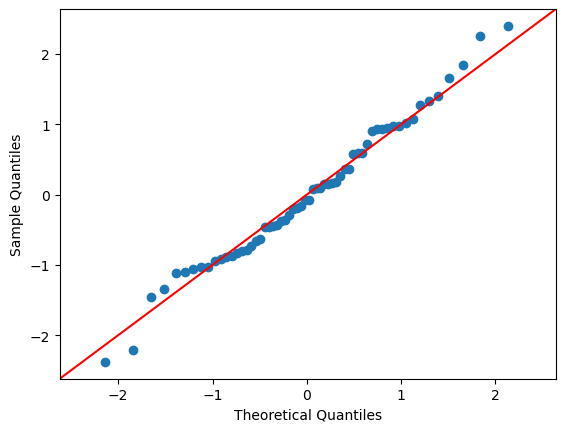

In [24]:
res = model.resid 
fig = sm.qqplot(res, stats.t, fit=True, line="45")
plt.show()

# Two-Way ANOVA using Pingouin
Here, Pingouin offers a very easy way to for ANOVA in Python.
Unfortunatelly, it doesn't work on the Kaggle site (in reason of this library, which i use), but you can copy these few lines of code...

In [25]:
import pingouin as pg
data = pd.read_csv(datafile)
data.head()

,Unnamed: 0,len,supp,dose
0,1,4.2,VC,0.5
1,2,11.5,VC,0.5
2,3,7.3,VC,0.5
3,4,5.8,VC,0.5
4,5,6.4,VC,0.5


In [26]:
aov = pg.anova(data, dv='len', between=['supp', 'dose'], detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,supp,205.350000,1,205.350000,15.571979,2.311828e-04,0.223825
1,dose,2426.434333,2,1213.217167,91.999965,4.046291e-18,0.773109
2,supp * dose,108.319000,2,54.159500,4.106991,2.186027e-02,0.132028
3,Residual,712.106000,54,13.187148,NaN,NaN,NaN


# Recursos:
* [Cienciadedatos.net](https://cienciadedatos.net/documentos/pystats09-analisis-de-varianza-anova-python)
* [Notebook original](https://www.kaggle.com/code/alexmaszanski/two-way-anova-with-python/comments): Tiene un error en el calculo de la interacción en la forma manual. Corregido aquí.
* [Notebook de kaggle más detallado](https://www.marsja.se/three-ways-to-carry-out-2-way-anova-with-python/): También contiene el error.